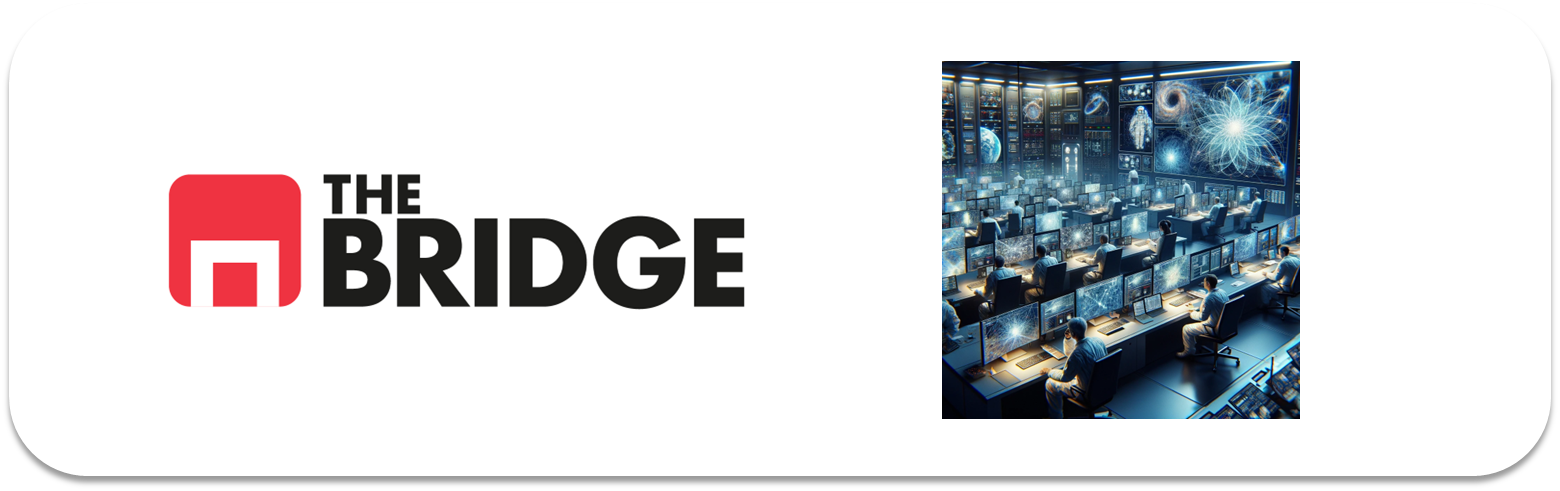

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from keras._tf_keras import keras
from keras._tf_keras.keras.applications import VGG19, InceptionV3, MobileNetV2
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

from utils import consolepy, functions

# Pylance not working
# from tensorflow.keras import datasets, layers, models
# from tensorflow.keras.preprocessing import image

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



## El problema de "Negocio"
Para este ejercicio vas a crear un clasificador automático de paisajes. Los datos los encontrarás en:

https://www.kaggle.com/datasets/puneet6060/intel-image-classification?select=seg_test 

Como `seg_train.zip` y `seg_test.zip` (o bien en el botón de download).  

NOTA: Son archivos bastante grandes (386MB en total). Por supuesto, no es necesario que tengas que mantenerlos en tu ordenador una vez realizado el ejercicio, bórralos si es el caso.



In [2]:
# Constantes
ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + 'seg_train/seg_train/'
TEST_PATH = ROOT_PATH + 'seg_test/seg_test/'
ZIP_FILE_PATH = ROOT_PATH + 'archive.zip'
IM_SIZE_32 = 32
IM_SIZE_128 = 128
NUM_CLASSES = 6


In [3]:
# Unzip imágenes
consolepy.unzip_files(ZIP_FILE_PATH, ROOT_PATH)

# Cargar imágenes con resolución 32x32
print('\nLeyendo "train (32x32)":')
X_train_32, y_train = functions.read_data(TRAIN_PATH, (IM_SIZE_32, IM_SIZE_32))
print('\nLeyendo "test (32x32)":')
X_test_32, y_test = functions.read_data(TEST_PATH, (IM_SIZE_32, IM_SIZE_32)) 

# Cargar imágenes con resolución 32x32
print('\nLeyendo "train (128x128)":')
X_train_128, y_train = functions.read_data(TRAIN_PATH, (IM_SIZE_128, IM_SIZE_128))
print('\nLeyendo "test" (128x128):')
X_test_128, y_test = functions.read_data(TEST_PATH, (IM_SIZE_128, IM_SIZE_128)) 

Extracted ./data/archive.zip to ./data/

Leyendo "train (32x32)":
buildings
forest
glacier
mountain
sea
street

Leyendo "test (32x32)":
buildings
forest
glacier
mountain
sea
street

Leyendo "train (128x128)":
buildings
forest
glacier
mountain
sea
street

Leyendo "test" (128x128):
buildings
forest
glacier
mountain
sea
street


In [4]:
# Ver el shape de las variables
print('X_train_32 shape: ', X_train_32.shape)
print('y_train_32 shape: ', y_train.shape)
print('X_test_32 shape: ', X_test_32.shape)
print('y_text_32 shape: ', y_test.shape)

X_train_32 shape:  (14034, 32, 32, 3)
y_train_32 shape:  (14034,)
X_test_32 shape:  (3000, 32, 32, 3)
y_text_32 shape:  (3000,)


*Para ahorrar tiempo en el futuro y porque ocupa menos, lo que voy a hacer es almacenar en local los numpy.ndarray.*

In [5]:
# Guardar las variables en archivos separados
np.save('./data/X_train_32.npy', X_train_32)
np.save('./data/X_test_32.npy', X_test_32)
np.save('./data/X_train_128.npy', X_train_128)
np.save('./data/X_test_128.npy', X_test_128)
np.save('./data/y_train.npy', y_train)
np.save('./data/y_test.npy', y_test)

#### Si no quiero volver a cargar las imágenes, ejecutar solo desde aquí.

In [3]:
# Cargar las variables guardadas
X_train_32 = np.load('./data/X_train_32.npy')
X_test_32 = np.load('./data/X_test_32.npy')
X_train_128 = np.load('./data/X_train_128.npy')
X_test_128 = np.load('./data/X_test_128.npy')
y_train = np.load('./data/y_train.npy')
y_test = np.load('./data/y_test.npy')

Visualizar las imagenes

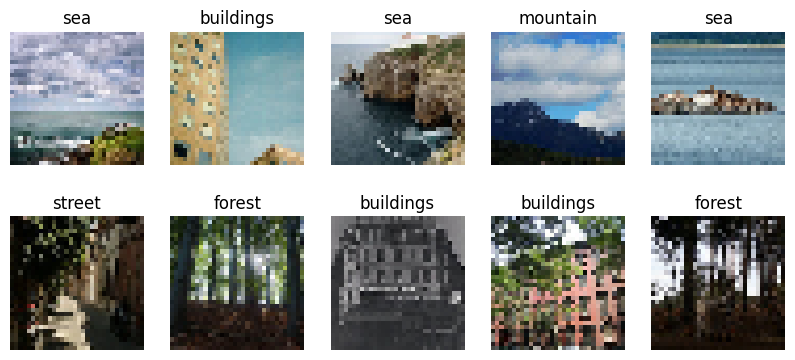

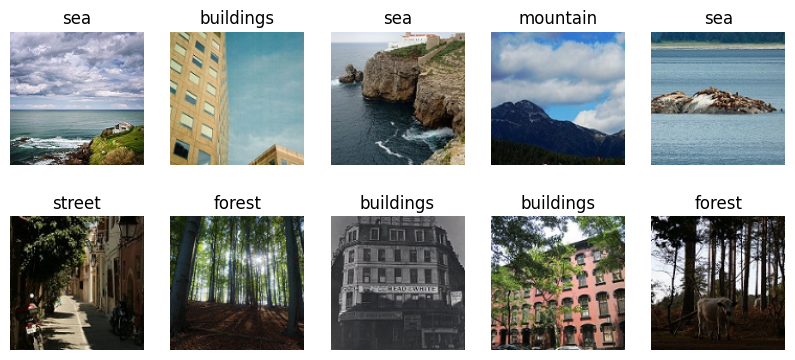

In [4]:
indices = np.random.randint(0, len(X_train_32), 10)
functions.show_images_batch(X_train_32[indices], titles=y_train[indices], n_cols=5)
functions.show_images_batch(X_train_128[indices], titles=y_train[indices], n_cols=5)

*A nuestra vista, la reduccion de la resolución afecta. Se puede cambiar el tamaño de resolución y probar, pero será a costa de tiempo de computación*

## Mini-EDA y tratamiento de las features

*Veamos la distribución de cada tipo de paisaje*

mountain     0.178994
glacier      0.171298
street       0.169731
sea          0.162035
forest       0.161821
buildings    0.156121
Name: proportion, dtype: float64

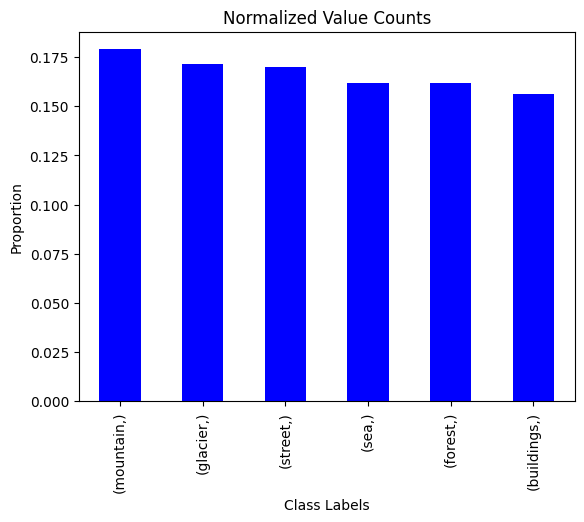

In [5]:
display(pd.Series(y_train).value_counts(normalize=True))

pd.DataFrame(y_train).value_counts(normalize=True).plot(kind='bar', color='blue')
plt.title('Normalized Value Counts')
plt.ylabel('Proportion')
plt.xlabel('Class Labels')
plt.show();

*Tenemos que construir un clasificador multiclase con 6 clases posibles que están más o menos balanceadas aunque hay una ligera superioridad de muestra de paisajes de montaña respecto al de edificios.*

*Y ahora un clásico de la normalización de imágenes (dividir por 255), barajar el set de train, y codificar el target para que sea más sencillo de evaluar.*

In [6]:
# Normalizar los datos
X_train_32 = X_train_32 / 255
X_test_32 = X_test_32 / 255

X_train_128 = X_train_128 / 255
X_test_128 = X_test_128 / 255

# Barajamos los datos. Interesa hacerlo con train puesto que de ellos aprende el modelo
X_train_32, X_train_128, y_train = shuffle(X_train_32,
                                           X_train_128,
                                           y_train, 
                                           random_state=42
                                           )

# Codificado del target
le = LabelEncoder()

y_train_num = le.fit_transform(y_train)
y_test_num = le.transform(y_test)

# Mostrar el mapeo original --> codificado
for original_class, encoded_class in zip(le.classes_, range(len(le.classes_))):
    print(f"{original_class} --> {encoded_class}")

buildings --> 0
forest --> 1
glacier --> 2
mountain --> 3
sea --> 4
street --> 5


*Recuerda que normalizar es bueno aunque estén en la misma escala por un lado porque las funciones de activación sulen trabajar mejor en rangos entre -1,0 y 1 (sobre todo las tanh, sigmoide, etc) y por otro porque valores altos de entrada sientan peor a la hora de hacer el gradiente descendente con backpropagation*

## Modelo ad-hoc

Es igual que el modelo del workout de la unidad anterior. 

Quiero hacer una estructura similar a la que hicimos en el workout y similar a esta, aunque habrá diferencias.

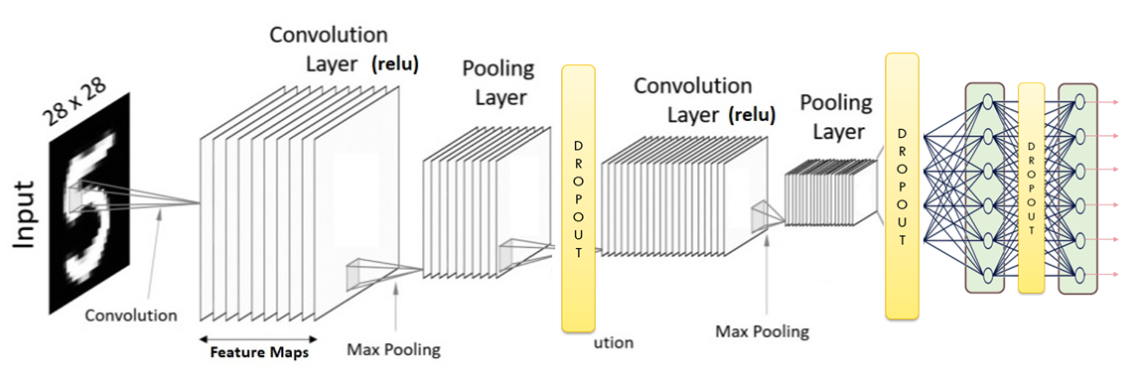


*Para escoger el optimizador me fijo en el tamaño del dataset*

In [7]:
print(X_train_32[0].shape)
print(X_train_32.size)

print(X_train_128[0].shape)
print(X_train_128.size)

(32, 32, 3)
43112448
(128, 128, 3)
689799168


*Dado el tamaño podemos usar un adam, cuyos hiperparámetros por defecto suelen funcionar bastante bien*

*Como el target es unidimensional usaré sparse_categorical_crossentropy, y como métrica dado el balanceo la accuracy.*


In [24]:
# Primero definimos las capas de la red, en este caso partimos de 30 filtros de 3x3, 
# seguido de una capa de pooling de 2x2, y un Dropout al 25 %.
# El input shape es el tamaño de las imágenes de entrada, en nuestro caso 32x32x3.
# El tamaño del kernel es pequeño pero suele ser de este tipo y más con resoluciones tan bajas, 
# el número de filtros está escogido de aquella manera.
layers = [keras.layers.Input(shape=(IM_SIZE_32, IM_SIZE_32, 3)),
          
          keras.layers.Conv2D(filters=30,
                              kernel_size=(3, 3),
                              padding='same', 
                              activation='relu'),         
          keras.layers.MaxPool2D(pool_size=(2, 2),
                                 strides=(2, 2)),
          keras.layers.Dropout(rate=0.25),
          
          # Segunda capa de convolución, pooling y dropout
          keras.layers.Conv2D(filters=15,
                              kernel_size = (3, 3),
                              padding = 'same',
                              activation = 'relu'),
          keras.layers.MaxPooling2D(pool_size=(2, 2),
                                    strides=(2, 2)),
          keras.layers.Dropout(rate=0.25),
          
          # Añadimos una capa de flatten para convertir la salida de la capa de dropout en un vector
          keras.layers.Flatten(),
          
          # Primera capa densa de clasificación, más dropout
          keras.layers.Dense(units=150, 
                             activation='relu'),
          keras.layers.Dropout(rate=0.25),
          
          # Segunda capa densa de clasificación, más dropout
          keras.layers.Dense(units=100, 
                             activation='relu'),
          keras.layers.Dropout(rate=0.25),
          
          # Añadimos la capa de salida con 6 neuronas, una por cada clase
          keras.layers.Dense(units=NUM_CLASSES, 
                             activation='softmax')
          ]


def prepare_model_ahhoc(layers):
    """
    Crear el modelo.
    """
    model = keras.models.Sequential(layers=layers)

    model.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy']
                )
    
    return model


model = prepare_model_ahhoc(layers=layers)
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_194 (Conv2D)             │ (None, 32, 32, 30)     │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 16, 16, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_195 (Conv2D)             │ (None, 16, 16, 15)     │         4,065 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 8, 8, 15)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 8, 8, 15)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 150)            │       144,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,761 (643.60 KB)

 Trainable params: 164,761 (643.60 KB)

 Non-trainable params: 0 (0.00 B)

Entrenar el modelo.

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.2517 - loss: 1.7124 - val_accuracy: 0.5440 - val_loss: 1.2078
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5317 - loss: 1.2093 - val_accuracy: 0.6049 - val_loss: 1.0217
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5912 - loss: 1.0473 - val_accuracy: 0.6445 - val_loss: 0.9673
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6342 - loss: 0.9574 - val_accuracy: 0.6769 - val_loss: 0.8778
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6611 - loss: 0.9179 - val_accuracy: 0.7129 - val_loss: 0.8070
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6875 - loss: 0.8517 - val_accuracy: 0.7079 - val_loss: 0.7885
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6981 - loss: 0.8287 - val_accuracy: 0.7349 - val_loss: 0.7521
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7247 - loss: 0.7650 - val_accuracy: 0.

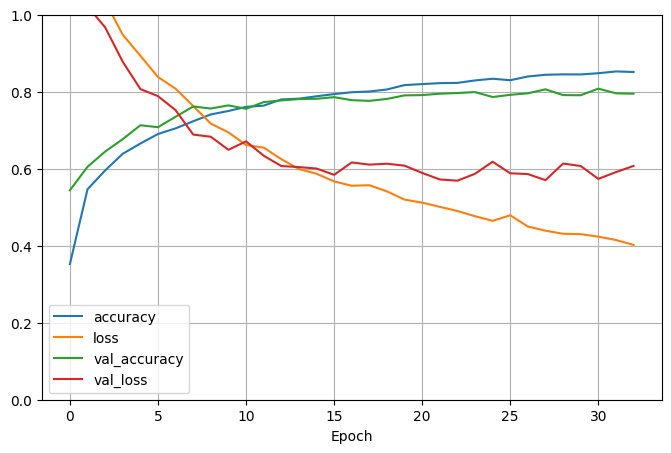

In [9]:
model = prepare_model_ahhoc(layers=layers)

# Queremos recuperar los pesos de la mejor de las epocas durante el periodo de patience
cb_earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 patience=10, 
                                                 restore_best_weights=True
                                                 )

# Entrenamiento
history = model.fit(x=X_train_32,
                    y=y_train_num,
                    batch_size=128,
                    epochs=100,
                    validation_split=0.2,
                    callbacks=[cb_earlystopping])

# Podemos ver como evoluciona el entrenamiento, en funcion de los epochs
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('Epoch')
plt.show()

*Pasadas las primeras 15 épocas, sólo estamos consiguiendo es hacer overfitting y de echo superadas las 20 épocas en la que incluso sube el error de validación y el de train sigue bajando*

#### Evaluar contra test

*El 80% de accuracy se traduce en el siguiente report*

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7730 - loss: 0.6420
[0.574208676815033, 0.7913333177566528]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

   buildings       0.78      0.69      0.73       437
      forest       0.93      0.94      0.94       474
     glacier       0.79      0.72      0.75       553
    mountain       0.75      0.78      0.76       525
         sea       0.71      0.80      0.76       510
      street       0.80      0.82      0.81       501

    accuracy                           0.79      3000
   macro avg       0.79      0.79      0.79      3000
weighted avg       0.79      0.79      0.79      3000



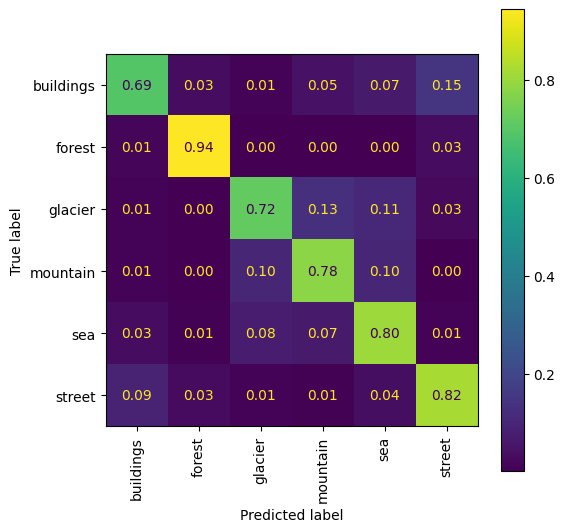

In [10]:
# Evaluar contra test
print(model.evaluate(X_test_32, y_test_num))
print('')

# Predicción
y_pred_num = np.array([np.argmax(pred_proba) for pred_proba in model.predict(X_test_32)])
y_pred = le.inverse_transform(y_pred_num)

# Classification Report
print(classification_report(y_test, y_pred))

# Matriz de confusión
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", ax=ax, values_format='.2f')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

### Modelo Ah-hoc (128x128)

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 24s 259ms/step - accuracy: 0.3748 - loss: 1.5135 - val_accuracy: 0.5729 - val_loss: 1.1223
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 257ms/step - accuracy: 0.5978 - loss: 1.0264 - val_accuracy: 0.6017 - val_loss: 1.0566
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 22s 250ms/step - accuracy: 0.6481 - loss: 0.9155 - val_accuracy: 0.6612 - val_loss: 0.9064
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 22s 246ms/step - accuracy: 0.7096 - loss: 0.7927 - val_accuracy: 0.7164 - val_loss: 0.7697
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 22s 246ms/step - accuracy: 0.7488 - loss: 0.6860 - val_accuracy: 0.7325 - val_loss: 0.7423
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 22s 245ms/step - accuracy: 0.7813 - loss: 0.5997 - val_accuracy: 0.7378 - val_loss: 0.7517
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 22s 244ms/step - accuracy: 0.8043 - loss: 0.5490 - val_accuracy: 0.7756 - val_loss: 0.6597
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 22s 245ms/step - accuracy: 0.8403 - loss: 0.4515 - val_accu

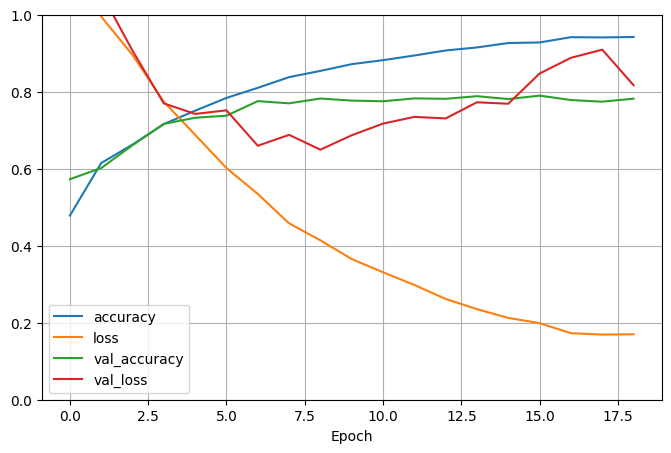

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7566 - loss: 0.7074
[0.6483986973762512, 0.7760000228881836]

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
              precision    recall  f1-score   support

   buildings       0.83      0.63      0.71       437
      forest       0.87      0.97      0.91       474
     glacier       0.72      0.79      0.76       553
    mountain       0.69      0.78      0.73       525
         sea       0.79      0.68      0.73       510
      street       0.81      0.80      0.80       501

    accuracy                           0.78      3000
   macro avg       0.78      0.77      0.77      3000
weighted avg       0.78      0.78      0.77      3000



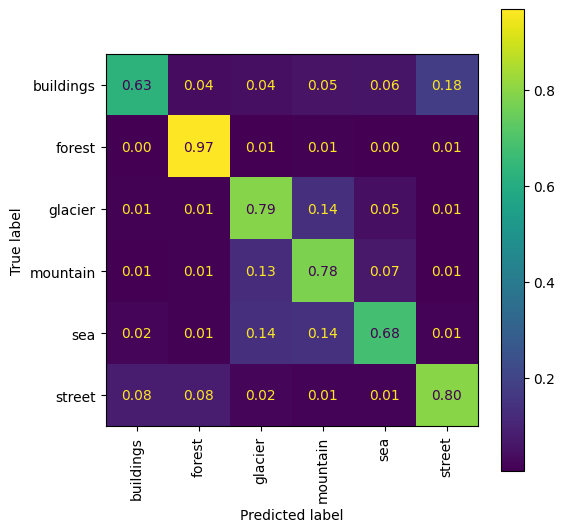

In [23]:
layers = [keras.layers.Input(shape=(IM_SIZE_128, IM_SIZE_128, 3)),
          
          # Primera capa de convolución, pooling y dropout
          keras.layers.Conv2D(filters=30,
                              kernel_size=(3, 3),
                              padding='same', 
                              activation='relu'),                            
          keras.layers.MaxPool2D(pool_size=(2, 2),
                                 strides=(2, 2)),
          keras.layers.Dropout(rate=0.25),
          
          # Segunda capa de convolución, pooling y dropout
          keras.layers.Conv2D(filters=15,
                              kernel_size=(3, 3),
                              padding='same',
                              activation='relu'),
          keras.layers.MaxPooling2D(pool_size=(2, 2),
                                    strides=(2, 2)),
          keras.layers.Dropout(rate=0.25),
          
          # Añadimos una capa de flatten para convertir la salida de la capa de dropout en un vector
          keras.layers.Flatten(),
          
          # Primera capa densa de clasificación, más dropout
          keras.layers.Dense(units=150, 
                             activation='relu'),
          keras.layers.Dropout(rate=0.25),
          
          # Segunda capa densa de clasificación, más dropout
          keras.layers.Dense(units=100, 
                             activation='relu'),
          keras.layers.Dropout(rate=0.25),
          
          # Añadimos la capa de salida con 6 neuronas, una por cada clase
          keras.layers.Dense(units=NUM_CLASSES, 
                             activation='softmax')
          ]

batch_size = 128
epochs = 50
X_train = X_train_128
X_test = X_test_128

model = prepare_model_ahhoc(layers=layers)

# Queremos recuperar los pesos de la mejor de las epocas durante el periodo de patience
cb_earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 patience=10, 
                                                 restore_best_weights= True
                                                 )

# Entrenamiento
history = model.fit(x=X_train,
                    y=y_train_num,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=[cb_earlystopping])

# Podemos ver como evoluciona el entrenamiento, en funcion de los epochs
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('Epoch')
plt.show()

# Evaluar contra test
print(model.evaluate(X_test, y_test_num))
print('')

# Predicción
y_pred_num = np.array([np.argmax(pred_proba) for pred_proba in model.predict(X_test)])
y_pred = le.inverse_transform(y_pred_num)

# Classification Report
print(classification_report(y_test, y_pred))

# Matriz de confusión
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", ax=ax, values_format='.2f')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

## Transfer-learning

Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

Voy a crear tres modelos: VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

Pero cuidado porque algunos tienen un input_shape mínimo con el que trabajar.


In [11]:

# Función para preparar el modelo
def prepare_model_TL(base_model, num_classes=6):
    """
    Prepara y compila un modelo de red neuronal utilizando un modelo base.
    """
    # Congelar las capas del modelo base
    for layer in base_model.layers:
        layer.trainable = False

    # Añadir capas personalizadas (cabeza del modelo)
    x = keras.layers.Flatten()(base_model.output)
    x = keras.layers.Dense(300, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(100, activation='relu')(x)
    x = keras.layers.Dropout(0.25)(x)
    output = keras.layers.Dense(num_classes, activation='softmax')(x)

    # Crear el modelo completo
    model = keras.models.Model(base_model.input, output)
    
    # Compilar el modelo
    model.compile(optimizer="adam", 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model


# Voy a crear tres modelos base
base_model_vgg19_32 = VGG19(include_top=False, 
                         weights='imagenet', 
                         input_shape=(IM_SIZE_32, IM_SIZE_32, 3)
                         )

base_model_vgg19_128 = VGG19(include_top=False, 
                          weights='imagenet', 
                          input_shape=(IM_SIZE_128, IM_SIZE_128, 3)
                          )

base_model_inceptionV3 = InceptionV3(include_top=False, 
                                     weights='imagenet', 
                                     input_shape=(75, 75, 3)
                                     )
base_model_mobileNetV2 = MobileNetV2(include_top=False, 
                                     weights='imagenet', 
                                     input_shape=(IM_SIZE_128, IM_SIZE_128, 3)
                                     )


# Crear modelos para VGG19, InceptionV3 y MobileNetV2
model_vgg19_32 = prepare_model_TL(base_model_vgg19_32)
model_vgg19_32.summary()

model_vgg19_128 = prepare_model_TL(base_model_vgg19_128)
model_vgg19_128.summary()

model_inceptionv3 = prepare_model_TL(base_model_inceptionV3)
model_inceptionv3.summary()

model_mobilenetv2 = prepare_model_TL(base_model_mobileNetV2)
model_mobilenetv2.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 300)            │       153,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 300)            │             

 Total params: 20,208,990 (77.09 MB)

 Trainable params: 184,606 (721.12 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 300)            │     2,457,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 300)            │             

 Total params: 22,512,990 (85.88 MB)

 Trainable params: 2,488,606 (9.49 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 75, 75, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 37, 37,    │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 37, 37,    │         96 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 37, 37,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 35, 35,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │         96 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 35, 35,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        192 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 17, 17,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 17, 17,    │      5,120 │ max_pooling2d_2[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 17, 17,    │        240 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 15, 15,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        576 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 15, 15,    │          0 │ batch_normalizat

 Total params: 22,448,190 (85.63 MB)

 Trainable params: 645,406 (2.46 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 8,432,990 (32.17 MB)

 Trainable params: 6,175,006 (23.56 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

#### Transfer-Learning: VGG-19 (32x32)

In [12]:
# Entrenar el modelo con EarlyStopping
batch_size = 128
epochs = 1

model = prepare_model_TL(base_model_vgg19_32)

cb_earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 min_delta=0.01,
                                                 patience=5,
                                                 restore_best_weights=True)

t_init = time()
history = model.fit(x=X_train_32,
                    y=y_train_num,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[cb_earlystopping],
                    validation_split=0.2
                    )
t_end = time()
print('Fit time:', t_end - t_init, 'seconds.')

88/88 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.4336 - loss: 1.4271 - val_accuracy: 0.6772 - val_loss: 0.8449
Fit time: 33.32573390007019 seconds.


*Bueno, en mi caso 32 segundos, y una accuracy bastante buena de primeras.*

*Ahora sí voy a aumentar el número de épocas y entrenar el modelo. `IMPORTANTE` volver a crear el modelo base, para que no siga entrenando desde donde se quedó la última vez.*

Epoch 1/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 32s 350ms/step - accuracy: 0.4109 - loss: 1.4588 - val_accuracy: 0.6851 - val_loss: 0.8569
Epoch 2/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 332ms/step - accuracy: 0.6399 - loss: 0.9300 - val_accuracy: 0.6958 - val_loss: 0.7986
Epoch 3/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 32s 369ms/step - accuracy: 0.6741 - loss: 0.8676 - val_accuracy: 0.7203 - val_loss: 0.7415
Epoch 4/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 334ms/step - accuracy: 0.6988 - loss: 0.8269 - val_accuracy: 0.7232 - val_loss: 0.7394
Epoch 5/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 329ms/step - accuracy: 0.7081 - loss: 0.7780 - val_accuracy: 0.7243 - val_loss: 0.7226
Epoch 6/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 331ms/step - accuracy: 0.7195 - loss: 0.7652 - val_accuracy: 0.7178 - val_loss: 0.7153
Epoch 7/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 43s 491ms/step - accuracy: 0.7254 - loss: 0.7321 - val_accuracy: 0.7335 - val_loss: 0.7009
Epoch 8/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 25s 290ms/step - accuracy: 0.7329 - loss: 0.7155 - val_accu

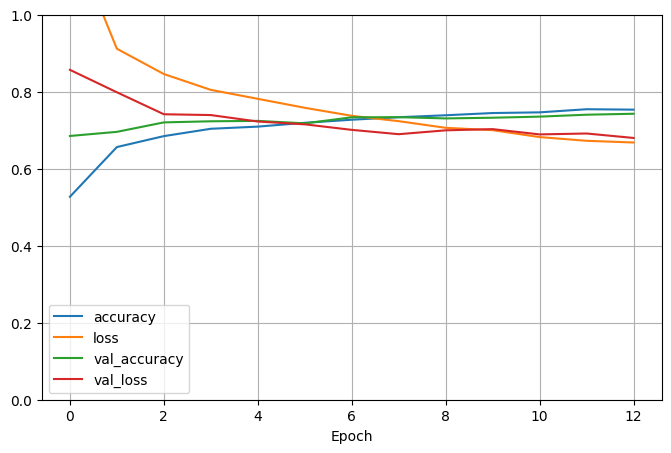

94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.7463 - loss: 0.6716

94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step
              precision    recall  f1-score   support

   buildings       0.71      0.70      0.70       437
      forest       0.90      0.90      0.90       474
     glacier       0.65      0.75      0.69       553
    mountain       0.70      0.69      0.69       525
         sea       0.75      0.63      0.68       510
      street       0.74      0.76      0.75       501

    accuracy                           0.73      3000
   macro avg       0.74      0.74      0.74      3000
weighted avg       0.74      0.73      0.73      3000



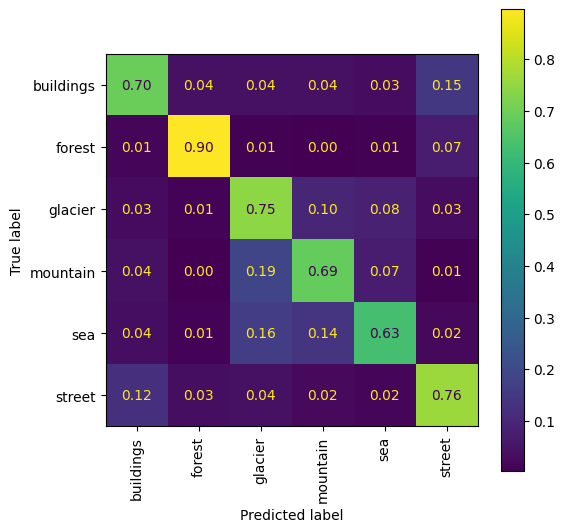

In [13]:
# Transfer Learning con imágenes de 32x32
batch_size = 128
epochs = 15
X_train = X_train_32
X_test = X_test_32

model = prepare_model_TL(base_model_vgg19_32)

cb_earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 min_delta=0.01,
                                                 patience=5,
                                                 restore_best_weights=True)

t_init = time()
history = model.fit(x=X_train,
                    y=y_train_num,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[cb_earlystopping],
                    validation_split=0.2
                    )
t_end = time()
print('Fit time:', t_end - t_init, 'seconds.')

# Podemos ver como evoluciona el entrenamiento, en funcion de los epochs
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('Epoch')
plt.show()

# Evaluamos el modelo
model.evaluate(X_test, y_test_num)
print('')

# Predicción
y_pred_num = np.array([np.argmax(pred_proba) for pred_proba in model.predict(X_test)])
y_pred = le.inverse_transform(y_pred_num)

# Classification Report
print(classification_report(y_test, y_pred))

# Matriz de confusión
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", ax=ax, values_format='.2f')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

Parece que a partir de la época 9 podríamos haber parado.



#### Transfer-Learning: VGG19 (128x128)

Ahora voy a hacerlo con las imágenes dde 128x128.

Epoch 1/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 351s 4s/step - accuracy: 0.5016 - loss: 1.3646 - val_accuracy: 0.8176 - val_loss: 0.4996
Epoch 2/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 352s 4s/step - accuracy: 0.7896 - loss: 0.5771 - val_accuracy: 0.8415 - val_loss: 0.4397
Epoch 3/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 351s 4s/step - accuracy: 0.8239 - loss: 0.5015 - val_accuracy: 0.8500 - val_loss: 0.3947
Epoch 4/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 350s 4s/step - accuracy: 0.8381 - loss: 0.4370 - val_accuracy: 0.8589 - val_loss: 0.3876
Epoch 5/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 352s 4s/step - accuracy: 0.8506 - loss: 0.4249 - val_accuracy: 0.8561 - val_loss: 0.3896
Epoch 6/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 351s 4s/step - accuracy: 0.8655 - loss: 0.3796 - val_accuracy: 0.8564 - val_loss: 0.3831
Epoch 7/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 355s 4s/step - accuracy: 0.8703 - loss: 0.3519 - val_accuracy: 0.8550 - val_loss: 0.3952
Epoch 8/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 352s 4s/step - accuracy: 0.8729 - loss: 0.3551 - val_accuracy: 0.8668 - v

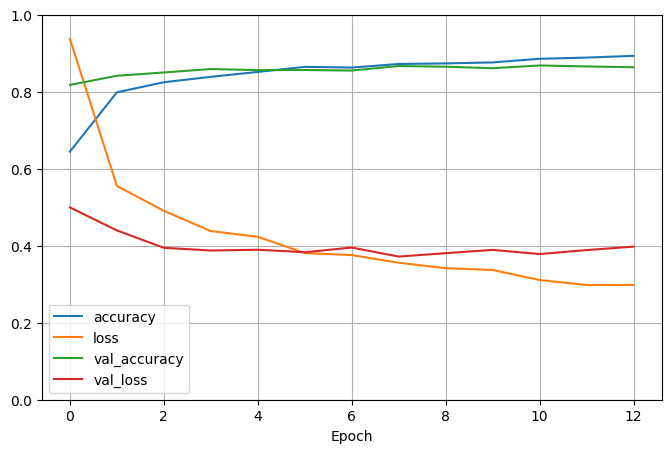

94/94 ━━━━━━━━━━━━━━━━━━━━ 78s 828ms/step - accuracy: 0.8745 - loss: 0.3365

94/94 ━━━━━━━━━━━━━━━━━━━━ 81s 863ms/step
              precision    recall  f1-score   support

   buildings       0.91      0.88      0.90       437
      forest       0.97      0.98      0.97       474
     glacier       0.85      0.77      0.81       553
    mountain       0.78      0.80      0.79       525
         sea       0.84      0.88      0.86       510
      street       0.88      0.93      0.90       501

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



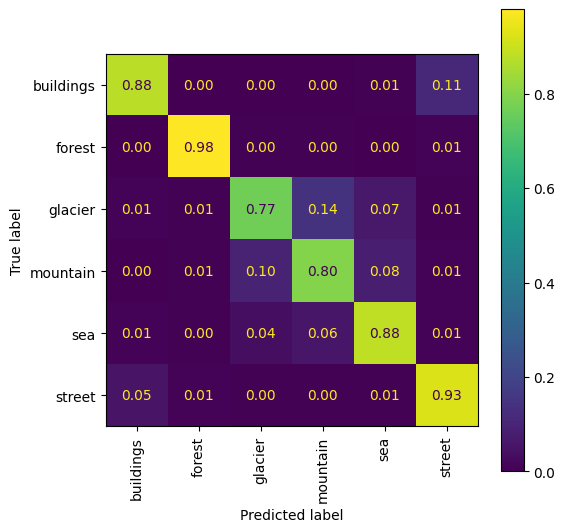

In [14]:
# Transfer Learning con imágenes de 32x32
batch_size = 128
epochs = 15
X_train = X_train_128
X_test = X_test_128

model = prepare_model_TL(base_model_vgg19_128)

cb_earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 min_delta=0.01,
                                                 patience=5,
                                                 restore_best_weights=True)

t_init = time()
history = model.fit(x=X_train,
                    y=y_train_num,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[cb_earlystopping],
                    validation_split=0.2
                    )
t_end = time()
print('Fit time:', t_end - t_init, 'seconds.')

# Podemos ver como evoluciona el entrenamiento, en funcion de los epochs
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('Epoch')
plt.show()

# Evaluamos el modelo
model.evaluate(X_test, y_test_num)
print('')

# Predicción
y_pred_num = np.array([np.argmax(pred_proba) for pred_proba in model.predict(X_test)])
y_pred = le.inverse_transform(y_pred_num)

# Classification Report
print(classification_report(y_test, y_pred))

# Matriz de confusión
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", ax=ax, values_format='.2f')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

#### Transfer-Learning: MobileNetV2 (128x128)

Epoch 1/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 40s 417ms/step - accuracy: 0.7130 - loss: 1.2424 - val_accuracy: 0.9127 - val_loss: 0.2659
Epoch 2/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 37s 426ms/step - accuracy: 0.8725 - loss: 0.3964 - val_accuracy: 0.9163 - val_loss: 0.2416
Epoch 3/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 36s 410ms/step - accuracy: 0.8923 - loss: 0.3135 - val_accuracy: 0.9166 - val_loss: 0.2393
Epoch 4/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 35s 403ms/step - accuracy: 0.9029 - loss: 0.2773 - val_accuracy: 0.9202 - val_loss: 0.2320
Epoch 5/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 35s 402ms/step - accuracy: 0.9197 - loss: 0.2382 - val_accuracy: 0.9238 - val_loss: 0.2400
Epoch 6/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 35s 403ms/step - accuracy: 0.9324 - loss: 0.1906 - val_accuracy: 0.9227 - val_loss: 0.2295
Epoch 7/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 61s 694ms/step - accuracy: 0.9381 - loss: 0.1745 - val_accuracy: 0.9238 - val_loss: 0.2309
Epoch 8/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.9401 - loss: 0.1688 - val_accura

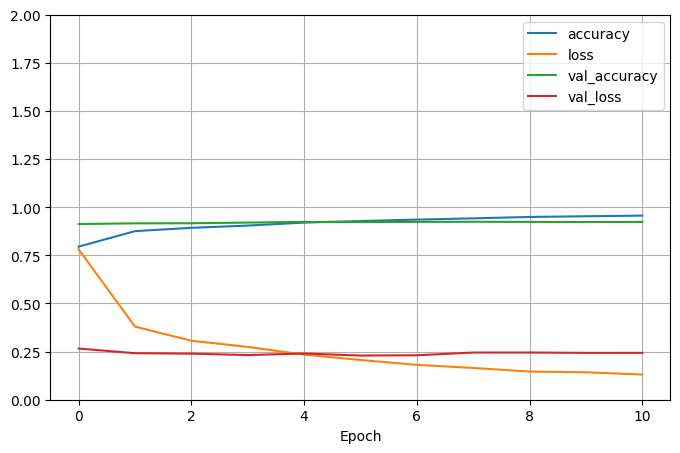

94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.9062 - loss: 0.2640
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step
              precision    recall  f1-score   support

   buildings       0.92      0.90      0.91       437
      forest       0.99      0.99      0.99       474
     glacier       0.88      0.81      0.84       553
    mountain       0.85      0.88      0.86       525
         sea       0.93      0.97      0.95       510
      street       0.93      0.94      0.93       501

    accuracy                           0.91      3000
   macro avg       0.91      0.92      0.91      3000
weighted avg       0.91      0.91      0.91      3000



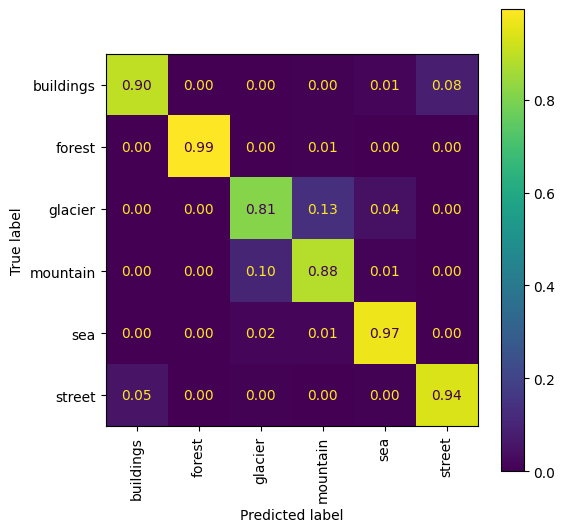

In [15]:
# Entrenar el modelo con EarlyStopping MODIFICADO
batch_size = 128
epochs = 15
X_train = X_train_128
X_test = X_test_128

model = prepare_model_TL(base_model_mobileNetV2)

cb_earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 min_delta=0.01,
                                                 patience=5,
                                                 restore_best_weights=True)

t_init = time()
history = model.fit(x=X_train,
                    y=y_train_num,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[cb_earlystopping],
                    validation_split=0.2
                    )
t_end = time()
print('Fit time:', t_end - t_init, 'seconds.')

# Podemos ver como evoluciona el entrenamiento, en funcion de los epochs
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.xlabel('Epoch')
plt.show()

# Evaluamos el modelo contra test
model.evaluate(X_test, y_test_num)

# Predicción
y_pred_num = np.array([np.argmax(pred_proba) for pred_proba in model.predict(X_test)])
y_pred = le.inverse_transform(y_pred_num)

# Classification Report
print(classification_report(y_test, y_pred))

# Matriz de confusión
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", ax=ax, values_format='.2f')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

## Fine-Tuning

Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

Además, voy a eliminar los pesos. 

In [16]:
# Función para preparar el modelo con fine-tuning (sin pesos preentrenados)
def prepare_model_FT(base_model, num_classes=6, fine_tune_at=100):
    """
    Prepara y compila un modelo de red neuronal utilizando un modelo base y permite fine-tuning
    desde la capa `fine_tune_at`. Sin utilizar los pesos preentrenados.
    
    Parámetros:
    - base_model: el modelo base (VGG19, InceptionV3, MobileNetV2, etc.)
    - num_classes: número de clases para la capa de salida
    - fine_tune_at: capa desde donde empezar el fine-tuning (especifica la capa que se descongelará)
    """
    
    # Congelar las capas hasta la capa fine_tune_at (dejar capas superiores entrenables)
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    for layer in base_model.layers[fine_tune_at:]:
        layer.trainable = True

    # Añadir la cabeza del modelo
    x = keras.layers.Flatten()(base_model.output)
    x = keras.layers.Dense(300, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(100, activation='relu')(x)
    x = keras.layers.Dropout(0.25)(x)
    output = keras.layers.Dense(num_classes, activation='softmax')(x)

    # Crear el modelo completo
    model = keras.models.Model(base_model.input, output)
    
    # Compilar el modelo con un learning rate bajo para el fine-tuning
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model


# Crear modelos base sin pesos preentrenados
base_model_vgg19_no_weights_32 = VGG19(include_top=False, 
                                       weights=None,
                                       input_shape=(IM_SIZE_32, IM_SIZE_32, 3)
                                       )

base_model_vgg19_no_weights_128 = VGG19(include_top=False, 
                                        weights=None,
                                        input_shape=(IM_SIZE_128, IM_SIZE_128, 3)
                                        )

base_model_inceptionV3_no_weights = InceptionV3(include_top=False, 
                                                weights=None, 
                                                input_shape=(75, 75, 3))

base_model_mobileNetV2_no_weights = MobileNetV2(include_top=False, 
                                                weights=None, 
                                                input_shape=(IM_SIZE_128, IM_SIZE_128, 3))

# Fine-tuning en los tres modelos base sin pesos preentrenados
model_vgg19_ft_no_weights_32 = prepare_model_FT(base_model_vgg19_no_weights_32, fine_tune_at=10)
model_vgg19_ft_no_weights_32.summary()

model_vgg19_ft_no_weights_128 = prepare_model_FT(base_model_vgg19_no_weights_128, fine_tune_at=10)
model_vgg19_ft_no_weights_128.summary()

model_inceptionv3_ft_no_weights = prepare_model_FT(base_model_inceptionV3_no_weights, fine_tune_at=100)
model_inceptionv3_ft_no_weights.summary()

# 3. Fine-tuning MobileNetV2 (sin pesos preentrenados y descongelar capas desde la 50 hacia adelante)
model_mobilenetv2_ft_no_weights = prepare_model_FT(base_model_mobileNetV2_no_weights, fine_tune_at=50)
model_mobilenetv2_ft_no_weights.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 300)            │       153,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 300)            │             

 Total params: 20,208,990 (77.09 MB)

 Trainable params: 18,473,502 (70.47 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 300)            │     2,457,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 300)            │             

 Total params: 22,512,990 (85.88 MB)

 Trainable params: 20,777,502 (79.26 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 75, 75, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 37, 37,    │        864 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 37, 37,    │         96 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 37, 37,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 35, 35,    │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │         96 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 35, 35,    │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        192 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 17, 17,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_99 (Conv2D)  │ (None, 17, 17,    │      5,120 │ max_pooling2d_6[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 17, 17,    │        240 │ conv2d_99[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_100 (Conv2D) │ (None, 15, 15,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        576 │ conv2d_100[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 15, 15,    │          0 │ batch_normalizat

 Total params: 22,448,190 (85.63 MB)

 Trainable params: 20,271,774 (77.33 MB)

 Non-trainable params: 2,176,416 (8.30 MB)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 8,432,990 (32.17 MB)

 Trainable params: 8,349,598 (31.85 MB)

 Non-trainable params: 83,392 (325.75 KB)

### Fine-Tuning: VGG19 (32x32)

Epoch 1/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 27s 291ms/step - accuracy: 0.1820 - loss: 1.7916 - val_accuracy: 0.1831 - val_loss: 1.7903
Epoch 2/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 25s 288ms/step - accuracy: 0.1754 - loss: 1.7908 - val_accuracy: 0.1831 - val_loss: 1.7902
Epoch 3/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 25s 287ms/step - accuracy: 0.1739 - loss: 1.7903 - val_accuracy: 0.1831 - val_loss: 1.7900
Epoch 4/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 25s 286ms/step - accuracy: 0.1785 - loss: 1.7901 - val_accuracy: 0.1831 - val_loss: 1.7881
Epoch 5/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 26s 292ms/step - accuracy: 0.1826 - loss: 1.7879 - val_accuracy: 0.1845 - val_loss: 1.7830
Epoch 6/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 25s 286ms/step - accuracy: 0.2140 - loss: 1.7818 - val_accuracy: 0.2725 - val_loss: 1.7649
Epoch 7/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 26s 291ms/step - accuracy: 0.2583 - loss: 1.7577 - val_accuracy: 0.2729 - val_loss: 1.7233
Epoch 8/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 26s 292ms/step - accuracy: 0.2754 - loss: 1.7106 - val_accu

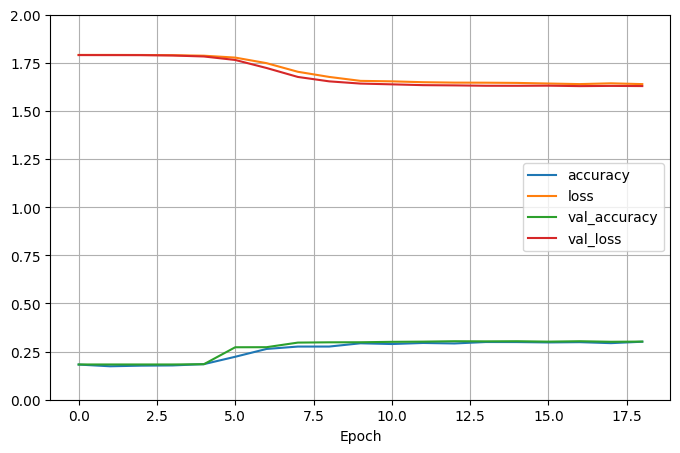

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.3318 - loss: 1.6005
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step
              precision    recall  f1-score   support

   buildings       0.00      0.00      0.00       437
      forest       0.46      0.71      0.56       474
     glacier       0.28      0.69      0.40       553
    mountain       0.25      0.42      0.31       525
         sea       0.00      0.00      0.00       510
      street       0.00      0.00      0.00       501

    accuracy                           0.31      3000
   macro avg       0.16      0.30      0.21      3000
weighted avg       0.17      0.31      0.22      3000



c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

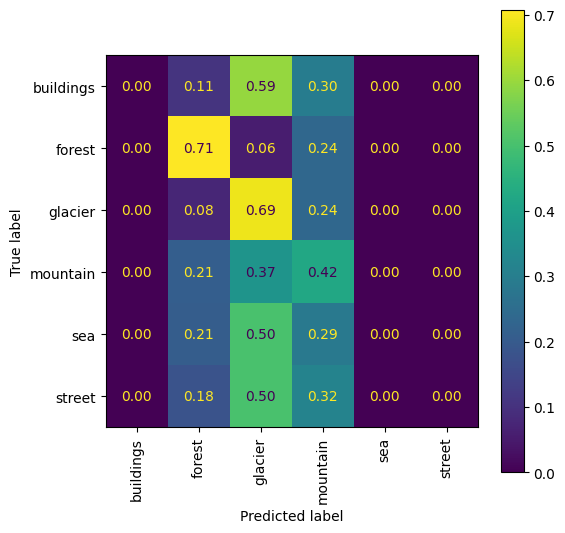

In [17]:
# Entrenar el modelo con EarlyStopping MODIFICADO
batch_size = 128
epochs = 40
X_train = X_train_32
X_test = X_test_32

model = prepare_model_FT(base_model_vgg19_no_weights_32)

cb_earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 min_delta=0.01,
                                                 patience=5,
                                                 restore_best_weights=True)

t_init = time()
history = model.fit(x=X_train,
                    y=y_train_num,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[cb_earlystopping],
                    validation_split=0.2
                    )
t_end = time()
print('Fit time:', t_end - t_init, 'seconds.')

# Podemos ver como evoluciona el entrenamiento, en funcion de los epochs
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.xlabel('Epoch')
plt.show()

# Evaluamos el modelo contra test
model.evaluate(X_test, y_test_num)

# Predicción
y_pred_num = np.array([np.argmax(pred_proba) for pred_proba in model.predict(X_test)])
y_pred = le.inverse_transform(y_pred_num)

# Classification Report
print(classification_report(y_test, y_pred))

# Matriz de confusión
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", ax=ax, values_format='.2f')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

### Fine-Tuning: VGG19 (128x128)

Epoch 1/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 348s 4s/step - accuracy: 0.1787 - loss: 1.7903 - val_accuracy: 0.1831 - val_loss: 1.7803
Epoch 2/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 348s 4s/step - accuracy: 0.2355 - loss: 1.7694 - val_accuracy: 0.3203 - val_loss: 1.7001
Epoch 3/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 350s 4s/step - accuracy: 0.3280 - loss: 1.6639 - val_accuracy: 0.4247 - val_loss: 1.5206
Epoch 4/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 346s 4s/step - accuracy: 0.3953 - loss: 1.4992 - val_accuracy: 0.4489 - val_loss: 1.3572
Epoch 5/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 346s 4s/step - accuracy: 0.4357 - loss: 1.3805 - val_accuracy: 0.4699 - val_loss: 1.3016
Epoch 6/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 347s 4s/step - accuracy: 0.4529 - loss: 1.3179 - val_accuracy: 0.4845 - val_loss: 1.2566
Epoch 7/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 346s 4s/step - accuracy: 0.4687 - loss: 1.2890 - val_accuracy: 0.4902 - val_loss: 1.2397
Epoch 8/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 346s 4s/step - accuracy: 0.4790 - loss: 1.2709 - val_accuracy: 0.5052 - v

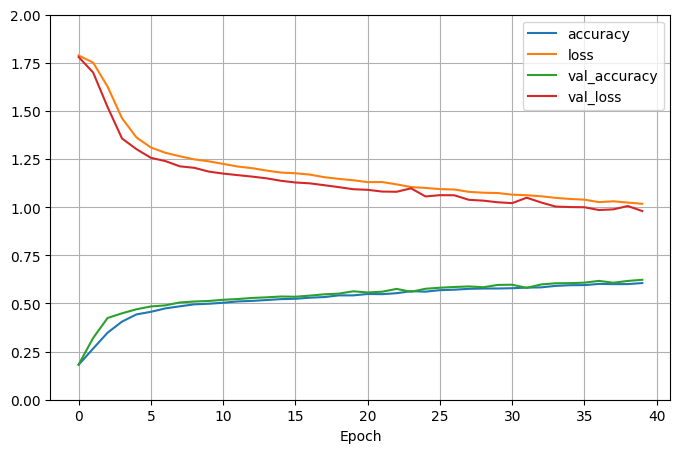

94/94 ━━━━━━━━━━━━━━━━━━━━ 75s 798ms/step - accuracy: 0.5941 - loss: 1.0545
94/94 ━━━━━━━━━━━━━━━━━━━━ 75s 800ms/step
              precision    recall  f1-score   support

   buildings       0.43      0.43      0.43       437
      forest       0.83      0.83      0.83       474
     glacier       0.59      0.62      0.61       553
    mountain       0.57      0.69      0.62       525
         sea       0.53      0.35      0.42       510
      street       0.65      0.71      0.68       501

    accuracy                           0.61      3000
   macro avg       0.60      0.60      0.60      3000
weighted avg       0.60      0.61      0.60      3000



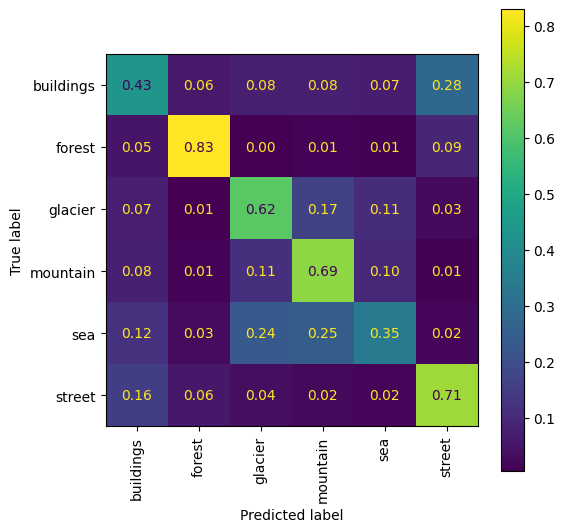

In [18]:
# Entrenar el modelo con EarlyStopping MODIFICADO
batch_size = 128
epochs = 40
X_train = X_train_128
X_test = X_test_128

model = prepare_model_FT(base_model_vgg19_no_weights_128)

cb_earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 min_delta=0.01,
                                                 patience=5,
                                                 restore_best_weights=True)

t_init = time()
history = model.fit(x=X_train,
                    y=y_train_num,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[cb_earlystopping],
                    validation_split=0.2
                    )
t_end = time()
print('Fit time:', t_end - t_init, 'seconds.')

# Podemos ver como evoluciona el entrenamiento, en funcion de los epochs
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.xlabel('Epoch')
plt.show()

# Evaluamos el modelo contra test
model.evaluate(X_test, y_test_num)

# Predicción
y_pred_num = np.array([np.argmax(pred_proba) for pred_proba in model.predict(X_test)])
y_pred = le.inverse_transform(y_pred_num)

# Classification Report
print(classification_report(y_test, y_pred))

# Matriz de confusión
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", ax=ax, values_format='.2f')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

### Fine-Tuning: MobileNetV2 (128x128)

Epoch 1/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 64s 646ms/step - accuracy: 0.1643 - loss: 2.4812 - val_accuracy: 0.1696 - val_loss: 1.7916
Epoch 2/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 53s 603ms/step - accuracy: 0.1767 - loss: 1.7914 - val_accuracy: 0.1696 - val_loss: 1.7914
Epoch 3/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 53s 602ms/step - accuracy: 0.1706 - loss: 1.7913 - val_accuracy: 0.1696 - val_loss: 1.7914
Epoch 4/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 53s 598ms/step - accuracy: 0.1728 - loss: 1.7911 - val_accuracy: 0.1696 - val_loss: 1.7916
Epoch 5/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 53s 598ms/step - accuracy: 0.1829 - loss: 1.7907 - val_accuracy: 0.1696 - val_loss: 1.7919
Epoch 6/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 53s 599ms/step - accuracy: 0.1821 - loss: 1.7906 - val_accuracy: 0.1696 - val_loss: 1.7921
Fit time: 329.2837464809418 seconds.


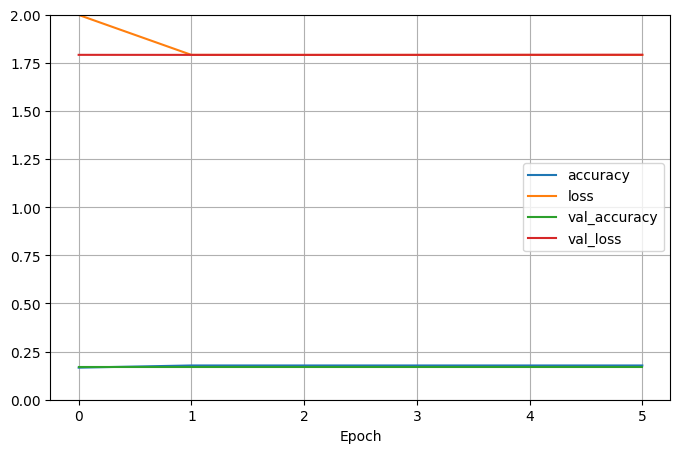

94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.0177 - loss: 1.7950
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step
              precision    recall  f1-score   support

   buildings       0.00      0.00      0.00       437
      forest       0.00      0.00      0.00       474
     glacier       0.00      0.00      0.00       553
    mountain       0.00      0.00      0.00       525
         sea       0.00      0.00      0.00       510
      street       0.17      1.00      0.29       501

    accuracy                           0.17      3000
   macro avg       0.03      0.17      0.05      3000
weighted avg       0.03      0.17      0.05      3000



c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

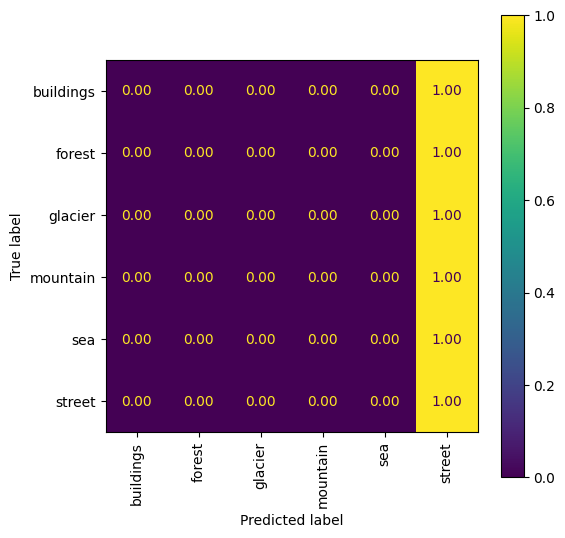

In [19]:
# Entrenar el modelo con EarlyStopping MODIFICADO
batch_size = 128
epochs = 40
X_train = X_train_128
X_test = X_test_128

model = prepare_model_FT(base_model_mobileNetV2_no_weights)

cb_earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 min_delta=0.01,
                                                 patience=5,
                                                 restore_best_weights=True)

t_init = time()
history = model.fit(x=X_train,
                    y=y_train_num,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[cb_earlystopping],
                    validation_split=0.2
                    )
t_end = time()
print('Fit time:', t_end - t_init, 'seconds.')

# Podemos ver como evoluciona el entrenamiento, en funcion de los epochs
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.xlabel('Epoch')
plt.show()

# Evaluamos el modelo contra test
model.evaluate(X_test, y_test_num)

# Predicción
y_pred_num = np.array([np.argmax(pred_proba) for pred_proba in model.predict(X_test)])
y_pred = le.inverse_transform(y_pred_num)

# Classification Report
print(classification_report(y_test, y_pred))

# Matriz de confusión
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", ax=ax, values_format='.2f')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

## Conclusiones


Modelo adhoc (dos capas convolucionales y 2 capas densasr): 
- Resolución 32x32, menos de 1 segundo de ejecución, y accuracy 79%. Lo que más equivoca son buildings con streets pero tiene una métricas considerablemente buenas en general, y muy poco coste computacional. Es un modelo sencillo de construir y de explicar.
- Aumento de resolución a 128x128. Ha aumentado el gasto computacional (7 minutos) y no se han mejorado demasiado los resultados: 80% accuracy.

Transfer-Learning:
- VGG19 (32x32), el tiempo de ejecución se ha aumentado (6 minutos), pero no ha mejorado ningún resultado: 75 % accuracy
- VGG19 (128x128), el tiempo de ejecución es aún más (80 minutos) pero los resultado sí han mejorado considereblemente: 87% de accuracy.
- `Mobile Net es lígero, la ejecución ha sido "rápida" (10 minutos) y es sin duda el mejor resultado, con un accuracy del 92% en solo 5 épocas.`

Fine-Tuning
- VGG19 (32x32). En mi caso con el fine tuning el tiempo de ejecución sí ha aumentado (8 minutos), como era de esperar, y el resultado ha sido muy malo. ¿Puede que haya despertado demasiadas capas para el entrenamiento?
- VGG19 (128x128), 4 horas de ejecucuón, y loss resultados  son malos también: 62% accuracy, aunque lo he parado en 40 épocas y no parece que haya convergido aún. Puede que con más épocas mejorase y que el modelo no hubiera "calentado" aún,
- MobileNetV2 (128x128), solo ha hecho 6 épocas y no ha mejorado nada el resultado: accuracy del 0.02%. ¡FATAL!.